# ResNext only with `pretrained=False` (LSTM) Model Deepfakedetection Faceforensics++

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
# Device configuration (GPU, MPS, or CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import seaborn as sns
import torchvision.transforms as transforms


In [8]:
# Define paths
PARENT_PATH_FAKE = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake'
PARENT_PATH_REAL = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_real'
TRANSFORMED_PATH_FAKE = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/transformed/ff_fake'
TRANSFORMED_PATH_REAL = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/transformed/ff_real'

# Define folders to use
REAL_FOLDERS = [
    '01__Kitchen_still_faces', '01__meeting_serious_faces', '01__podium_speech_happy_faces', '01__talking_against_wall_faces', '02__kitchen_pan_faces',
    '02__kitchen_still_faces', '02__outside_talking_still_laughing_faces', '02__podium_speech_happy_faces', '02__talking_against_wall_faces', '02__talking_angry_couch_faces',
    '03__kitchen_still_faces', '03__outside_talking_still_laughing_faces', '03__podium_speech_happy_faces', '03__talking_against_wall_faces', '03__talking_angry_couch_faces',
    '04__kitchen_still_faces', '04__outside_talking_still_laughing_faces', '04__podium_speech_happy_faces', '04__talking_against_wall_faces', '04__talking_angry_couch_faces',
    '05__hugging_happy_faces', '05__kitchen_pan_faces', '05__kitchen_still_faces', '05__podium_speech_happy_faces', '05__talking_against_wall_faces',
    '06__kitchen_still_faces', '06__outside_talking_still_laughing_faces', '06__podium_speech_happy_faces', '06__talking_against_wall_faces', '06__talking_angry_couch_faces',
    '06__walking_down_indoor_hall_disgust_faces', '08__kitchen_still_faces', '10__talking_angry_couch_faces', '11__podium_speech_happy_faces', '13__talking_against_wall_faces'
]

FAKE_FOLDERS = [
    '01_02__talking_angry_couch__YVGY8LOK_faces', '01_02__walking_down_indoor_hall_disgust__YVGY8LOK_faces', '02_04__podium_speech_happy__8CH7R4LW_faces', '07_02__talking_against_wall__U7DEOZNV_faces',
    '21_02__kitchen_pan__Z0XHPQAR_faces', '21_09__kitchen_pan__Z8H2TRCI_faces', '21_09__kitchen_still__LBQf8ZN1_faces', '03_06__podium_speech_happy__1IXGY2FK_faces',
    '15_04__talking_against_wall__46TJ9IOJ_faces', '27_02__talking_angry_couch__GVFLSZD5_faces', '02_15__kitchen_still__XNJIS4S3_faces', '21_03__outside_talking_still_laughing__YCSEBZO4_faces',
    '26_20__podium_speech_happy__01OJA93K_faces', '14_03__talking_against_wall__38OVCK3X_faces', '01_09__talking_angry_couch__P70H1JB0_faces', '07_04__kitchen_still__M2NBCLFR_faces',
    '07_02__outside_talking_still_laughing__1ZE4HC06_faces', '02_04__podium_speech_happy__8CH7R4LW_faces', '15_03__walking_outside_cafe_disgusted__GZNLO4X9_faces', '03_04__talking_angry_couch__T04P6ELC_faces',
    '16_05__hugging_happy__V7BK27TX_faces', '03_11__kitchen_pan__P08VGHTA_faces', '03_07__kitchen_pan__WPT3Z2KN_faces', '02_15__podium_speech_happy__I8G2LWD1_faces',
    '03_14__talking_against_wall__ZC2KYASW_faces', '03_14__kitchen_pan__ZC2KYASW_faces', '06_18__outside_talking_still_laughing__DEA1TCLN_faces', '07_26__podium_speech_happy__FGNGC2GT_faces',
    '09_21__talking_against_wall__LBQF8ZN1_faces', '12_13__talking_angry_couch__WCPCP2TD_faces', '06_18__walking_down_indoor_hall_disgust__DEA1TCLN_faces', '05_16__kitchen_still__053HPS1G_faces',
    '01_20__talking_angry_couch__FW94AIMJ_faces', '06_15__podium_speech_happy__QRCD27P8_faces', '09_13__talking_against_wall__LPT427RY_faces'
]

In [10]:
class DeepFakeDataset(Dataset):
    def __init__(self, parent_path_fake, parent_path_real, fake_folders, real_folders):
        self.data = []

        # Load fake data
        for folder in fake_folders:
            folder_path = os.path.join(parent_path_fake, folder)
            frames = [os.path.join(folder_path, frame) for frame in os.listdir(folder_path) if frame.endswith('.jpg')]
            self.data.extend([(frame, 1) for frame in frames])
            print(f"Loaded {len(frames)} fake frames from {folder_path}")  # Debug statement

        # Load real data
        for folder in real_folders:
            folder_path = os.path.join(parent_path_real, folder)
            frames = [os.path.join(folder_path, frame) for frame in os.listdir(folder_path) if frame.endswith('.jpg')]
            self.data.extend([(frame, 0) for frame in frames])
            print(f"Loaded {len(frames)} real frames from {folder_path}")  # Debug statement

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        frame = Image.open(frame_path).convert('RGB')  # Load image using PIL
        frame = transforms.ToTensor()(frame)  # Convert image to tensor
        return frame, label

# Initialize the dataset
dataset = DeepFakeDataset(parent_path_fake=PARENT_PATH_FAKE, parent_path_real=PARENT_PATH_REAL, fake_folders=FAKE_FOLDERS, real_folders=REAL_FOLDERS)

# Check the length of the dataset
print(f"Total samples in dataset: {len(dataset)}")  # Should be greater than 0


Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake/01_02__talking_angry_couch__YVGY8LOK_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake/01_02__walking_down_indoor_hall_disgust__YVGY8LOK_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake/02_04__podium_speech_happy__8CH7R4LW_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake/07_02__talking_against_wall__U7DEOZNV_faces
Loaded 100 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake/21_02__kitchen_pan__Z0XHPQAR_faces
Loaded 108 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake/21_09__kitchen_pan__Z8H2TRCI_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/ff_fake/21_09__kitchen_still__LBQf8ZN1_faces


In [6]:
# Split the dataset into train, test, and validation
if len(dataset) > 0:
    train_size = int(0.7 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Print the number of images in each set
    print(f"Number of frames (images) in the training set: {len(train_dataset)}")
    print(f"Number of frames (images) in the validation set: {len(val_dataset)}")
    print(f"Number of frames (images) in the test set: {len(test_dataset)}")
    
    print("DataLoaders created successfully.")
else:
    print("Dataset is empty. Please check the paths and loading logic.")


Number of frames (images) in the training set: 7134
Number of frames (images) in the validation set: 2038
Number of frames (images) in the test set: 1020
DataLoaders created successfully.


## 10 epc, lr = 0.0001

In [12]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [13]:
# Define the Model: ResNeXt50 from scratch for classification (no LSTM)
class DeepFakeDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepFakeDetectionModel, self).__init__()
        
        # Initialize ResNeXt50 from scratch (using default architecture)
        self.base_model = models.resnext50_32x4d(pretrained=False)  # No pre-trained weights
        
        # Adjust the final fully connected (FC) layer to match the number of classes
        self.base_model.fc = nn.Linear(2048, num_classes)  # ResNeXt50 outputs 2048 features, modify FC for num_classes

    def forward(self, x):
        # Input shape should be (batch_size, c, h, w)
        if len(x.size()) == 4:
            # Forward pass through ResNeXt50
            out = self.base_model(x)  # Output shape: (batch_size, num_classes)
        else:
            raise ValueError("Expected input to have 4 dimensions (batch_size, c, h, w)")
        
        return out

In [14]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=10):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [16]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=10):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


USED

In [17]:
def test_model_with_samples_last_frames(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_inputs = []  # Store all input frames for final selection

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels, predictions, and inputs for post-loop processing
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_inputs.extend(inputs.cpu())  # Store frames in CPU memory

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="#FF6F61", lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color="#6B5B95", lw=2, linestyle='--', label='Random Guess')
    plt.fill_between(fpr, tpr, color="#FFA07A", alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')
    plt.show()

    # Select last 3 frames for each class (Real and Fake) based on final predictions
    real_samples = [all_inputs[i] for i in range(len(all_labels)) if all_preds[i] == 0][-3:]
    fake_samples = [all_inputs[i] for i in range(len(all_labels)) if all_preds[i] == 1][-3:]

    # Display 3 frames from each class (Real and Fake) from the last occurrences
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Sample Frames (Last 3 Frames from Dataloader): Real Class (Top) and Fake Class (Bottom)', fontsize=16, weight = 'bold')

    for i in range(3):
        if i < len(real_samples):
            axes[0, i].imshow(real_samples[i].permute(1, 2, 0).numpy())
            axes[0, i].axis('off')
            axes[0, i].set_title("Real")

        if i < len(fake_samples):
            axes[1, i].imshow(fake_samples[i].permute(1, 2, 0).numpy())
            axes[1, i].axis('off')
            axes[1, i].set_title("Fake")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust to fit the title
    plt.show()

    return test_loss, test_acc


In [18]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch):
    epochs = range(1, num_epoch + 1)

    # Create the figure and subplots for loss and accuracy
    plt.figure(figsize=(12, 5))

    # Define more vibrant colors for better visibility
    train_loss_color = '#1f77b4'  
    val_loss_color = '#ff7f0e'    
    train_acc_color = '#1f77b4'   
    val_acc_color = '#ff7f0e'     
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', color=train_loss_color, linestyle='-', label='Training Loss')
    plt.plot(epochs, val_losses, marker='o', color=val_loss_color, linestyle='-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0.0, max(max(train_losses), max(val_losses)) * 1.1)  # Set y-axis limits for loss
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', color=train_acc_color, linestyle='-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, marker='o', color=val_acc_color, linestyle='-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Adjust layout for better spacing between subplots
    plt.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [19]:
# Run training for 10 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=10)

Epoch 1/10, Train Loss: 0.4793, Train Accuracy: 0.7656
Epoch 2/10, Train Loss: 0.3011, Train Accuracy: 0.8737
Epoch 3/10, Train Loss: 0.2205, Train Accuracy: 0.9101
Epoch 4/10, Train Loss: 0.1752, Train Accuracy: 0.9341
Epoch 5/10, Train Loss: 0.1149, Train Accuracy: 0.9568
Epoch 6/10, Train Loss: 0.1040, Train Accuracy: 0.9617
Epoch 7/10, Train Loss: 0.0702, Train Accuracy: 0.9727
Epoch 8/10, Train Loss: 0.0586, Train Accuracy: 0.9791
Epoch 9/10, Train Loss: 0.0454, Train Accuracy: 0.9850
Epoch 10/10, Train Loss: 0.0407, Train Accuracy: 0.9860
Training complete.


In [20]:
# Run validation for 10 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=10)

Epoch 1/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 2/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 3/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 4/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 5/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 6/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 7/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 8/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 9/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Epoch 10/10, Validation Loss: 1.6170, Validation Accuracy: 0.7326
Validation complete.


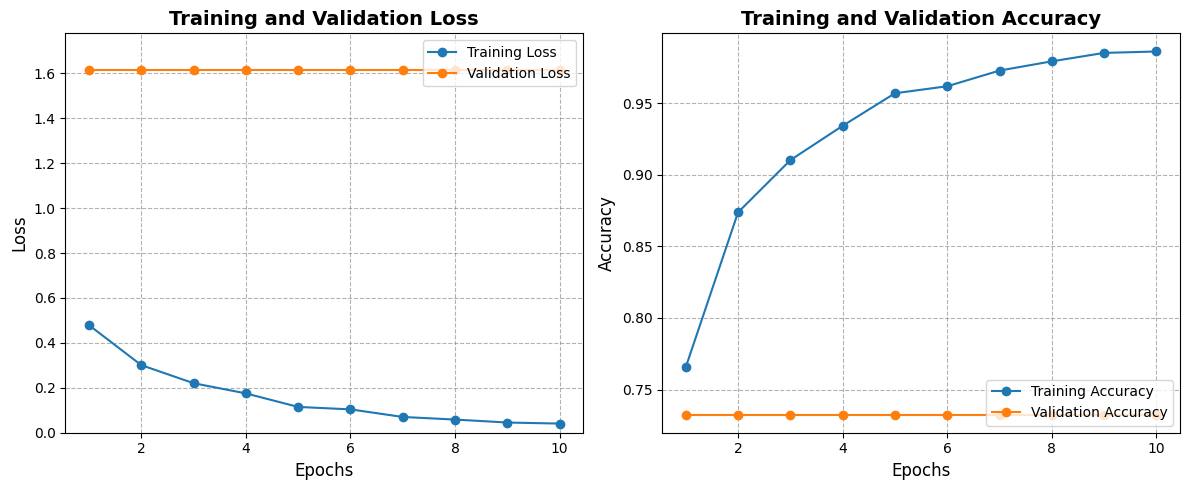

In [21]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=10)

Test Loss: 1.7445, Test Accuracy: 0.7304
Confusion Matrix:
[[509   0]
 [275 236]]


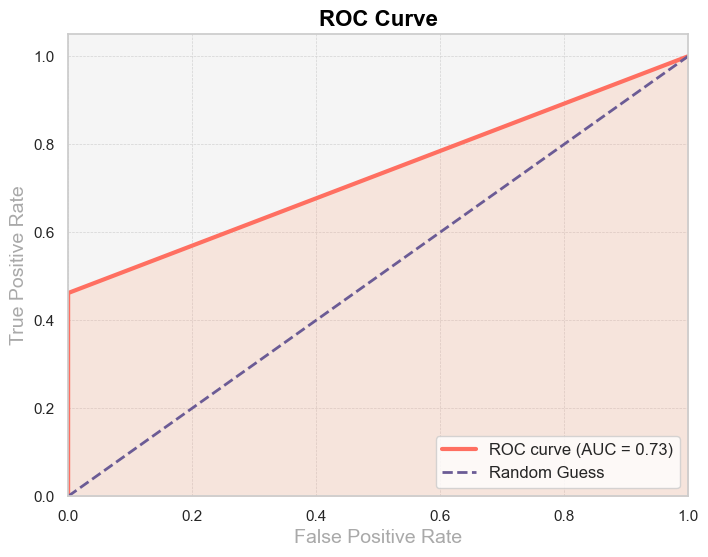

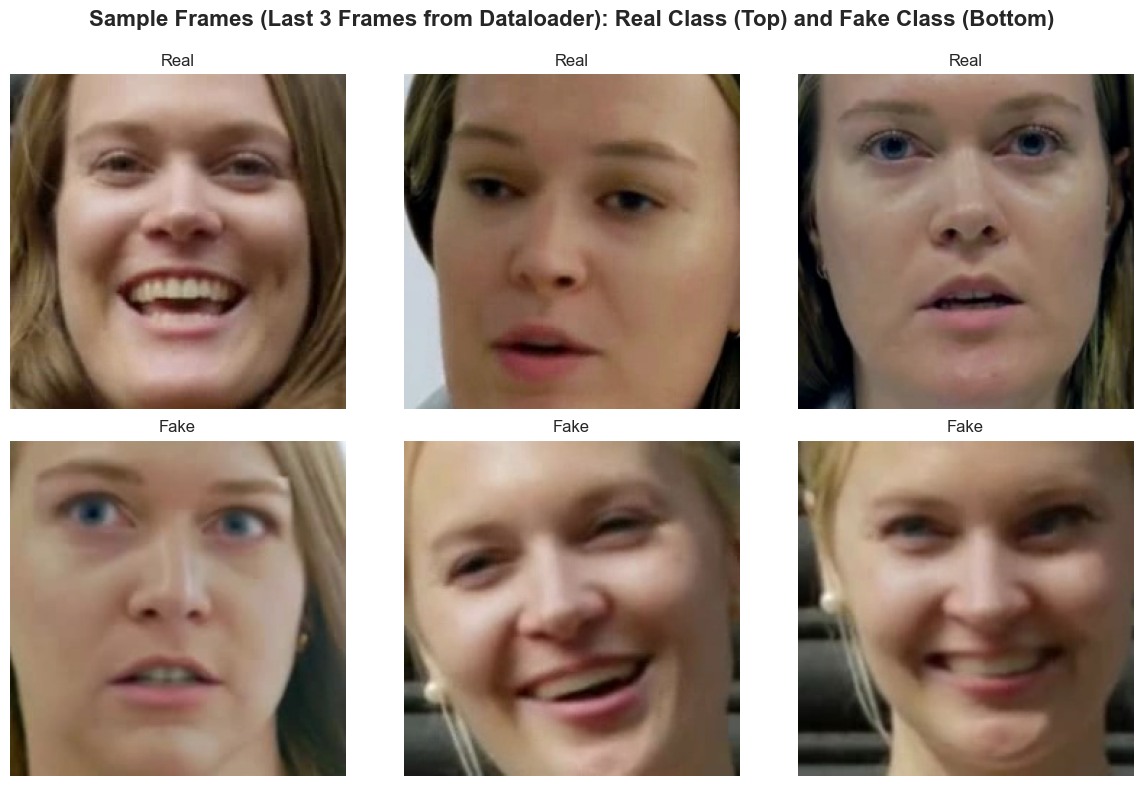

In [22]:
test_loss, test_acc = test_model_with_samples_last_frames(model, test_loader, criterion, device) # using used

Test Loss: 1.7445, Test Accuracy: 0.7304
Confusion Matrix:
[[509   0]
 [275 236]]


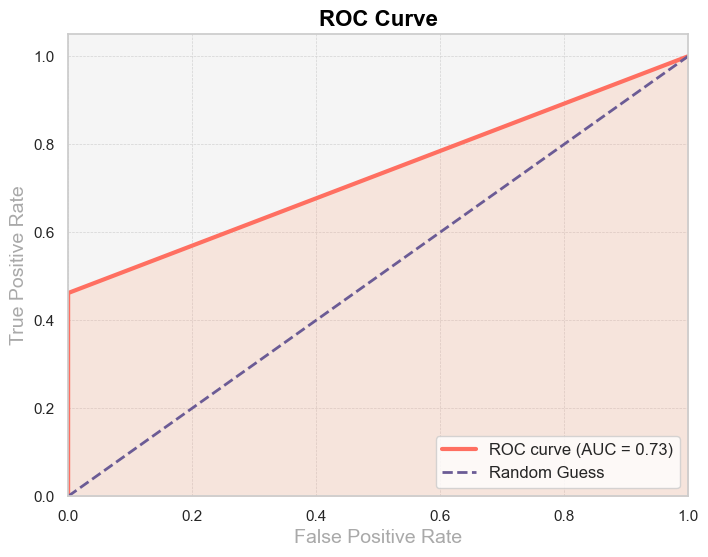

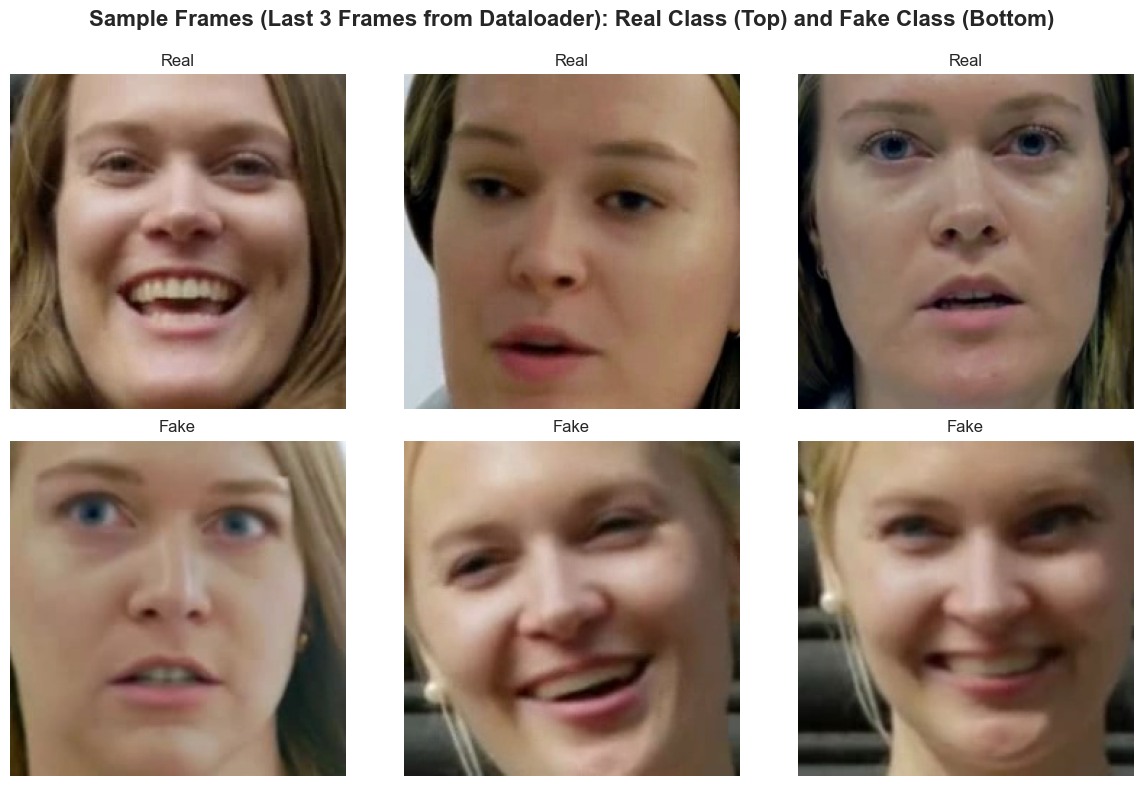

In [24]:
test_loss, test_acc = test_model_with_samples_last_frames(model, test_loader, criterion, device)

In [25]:
model.to(device)  # Move the model back to the MPS device

DeepFakeDetectionModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

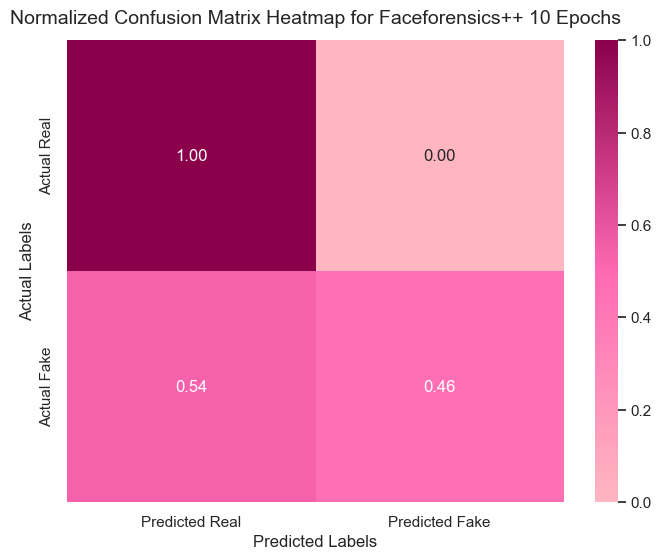

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[509, 0],  # Actual Real
                               [275, 236]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark hotpink
cmap = LinearSegmentedColormap.from_list("custom_hotpink", ["#ffb6c1", "hotpink", "#8b004b"])  # Light to dark pink

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Faceforensics++ 10 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## 10 eoc, lr = 0.01

In [27]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [28]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=10):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [29]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=10):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [30]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [31]:
import seaborn, matplotlib

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch):
    epochs = range(1, num_epoch + 1)

    # Create the figure and subplots for loss and accuracy
    plt.figure(figsize=(12, 5))

    # Define more vibrant colors for better visibility
    train_loss_color = '#1f77b4'  
    val_loss_color = '#ff7f0e'    
    train_acc_color = '#1f77b4'   
    val_acc_color = '#ff7f0e'     
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', color=train_loss_color, linestyle='-', label='Training Loss')
    plt.plot(epochs, val_losses, marker='o', color=val_loss_color, linestyle='-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0.0, max(max(train_losses), max(val_losses)) * 1.1)  # Set y-axis limits for loss
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', color=train_acc_color, linestyle='-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, marker='o', color=val_acc_color, linestyle='-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Adjust layout for better spacing between subplots
    plt.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [32]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [33]:
# Run training for 15 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=10)

Epoch 1/10, Train Loss: 0.8224, Train Accuracy: 0.5592
Epoch 2/10, Train Loss: 0.6151, Train Accuracy: 0.6536
Epoch 3/10, Train Loss: 0.4942, Train Accuracy: 0.7560
Epoch 4/10, Train Loss: 0.4078, Train Accuracy: 0.8172
Epoch 5/10, Train Loss: 0.3509, Train Accuracy: 0.8462
Epoch 6/10, Train Loss: 0.2943, Train Accuracy: 0.8765
Epoch 7/10, Train Loss: 0.2344, Train Accuracy: 0.9040
Epoch 8/10, Train Loss: 0.1698, Train Accuracy: 0.9329
Epoch 9/10, Train Loss: 0.1606, Train Accuracy: 0.9371
Epoch 10/10, Train Loss: 0.1378, Train Accuracy: 0.9466
Training complete.


In [34]:
# Run validation for 15 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=10)

Epoch 1/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 2/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 3/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 4/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 5/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 6/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 7/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 8/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 9/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Epoch 10/10, Validation Loss: 2.7471, Validation Accuracy: 0.5893
Validation complete.


Test Loss: 2.7991, Test Accuracy: 0.5833
Confusion Matrix:
[[508   1]
 [424  87]]


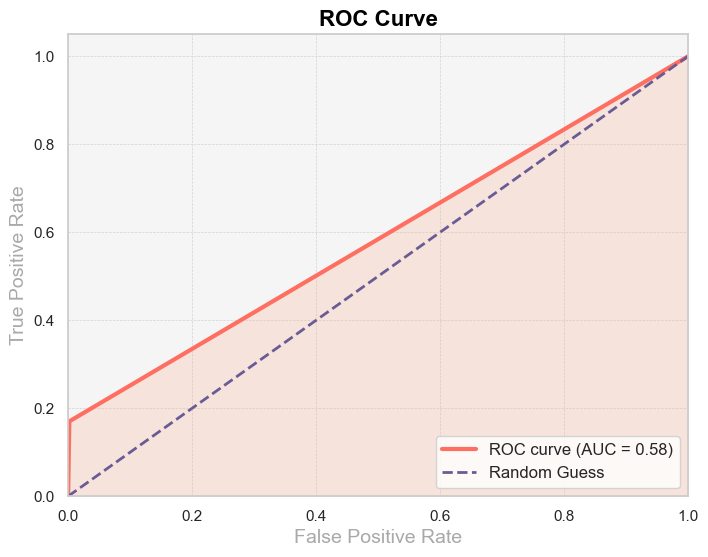

In [35]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

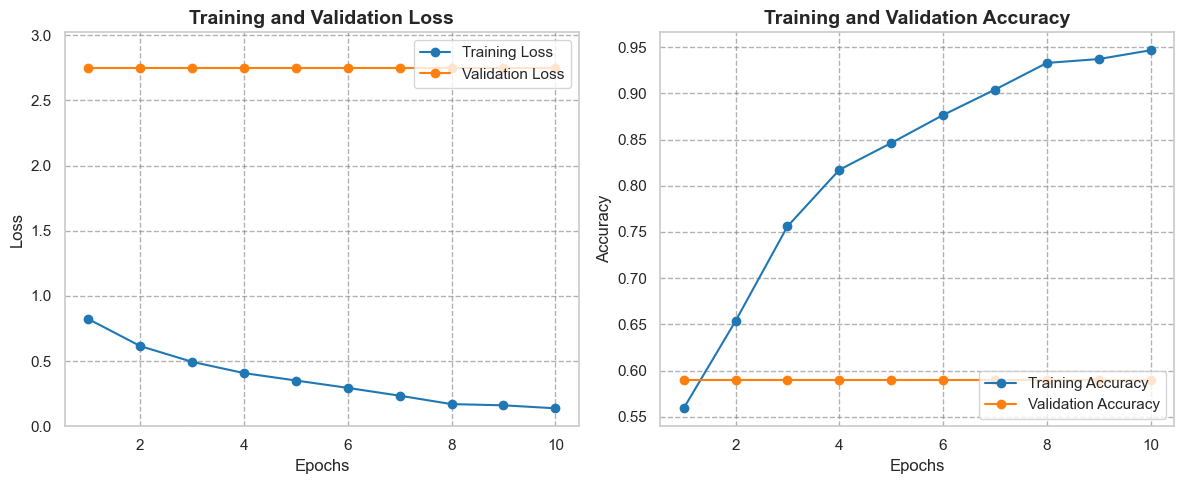

In [36]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=10)

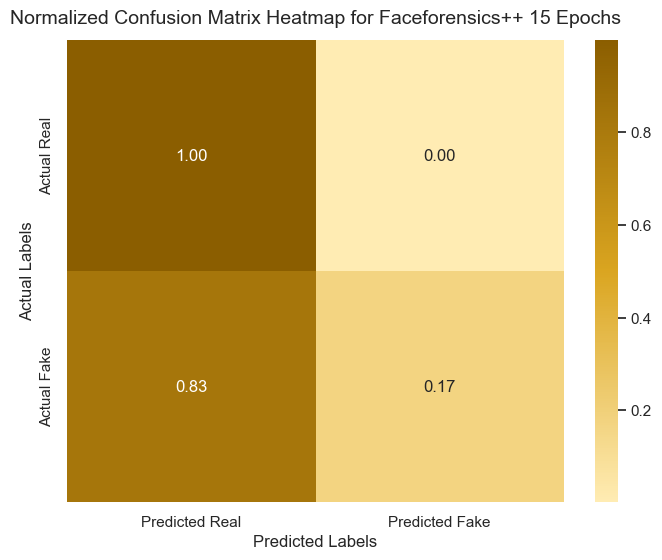

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[508, 1],  # Actual Real
                               [424, 87]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark goldenrod
cmap = LinearSegmentedColormap.from_list("custom_goldenrod", ["#ffecb3", "goldenrod", "#8b5e00"])  # Light to dark goldenrod

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Faceforensics++ 15 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## epoch 15, lr=0.0001

In [39]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [40]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=15):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [41]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=15):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [42]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [43]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [44]:
# Run training for 15 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=15)

Epoch 1/15, Train Loss: 0.4801, Train Accuracy: 0.7653
Epoch 2/15, Train Loss: 0.3386, Train Accuracy: 0.8593
Epoch 3/15, Train Loss: 0.2361, Train Accuracy: 0.9023
Epoch 4/15, Train Loss: 0.1755, Train Accuracy: 0.9295
Epoch 5/15, Train Loss: 0.1122, Train Accuracy: 0.9567
Epoch 6/15, Train Loss: 0.0820, Train Accuracy: 0.9708
Epoch 7/15, Train Loss: 0.0680, Train Accuracy: 0.9750
Epoch 8/15, Train Loss: 0.0555, Train Accuracy: 0.9784
Epoch 9/15, Train Loss: 0.0457, Train Accuracy: 0.9847
Epoch 10/15, Train Loss: 0.0504, Train Accuracy: 0.9818
Epoch 11/15, Train Loss: 0.0428, Train Accuracy: 0.9853
Epoch 12/15, Train Loss: 0.0338, Train Accuracy: 0.9886
Epoch 13/15, Train Loss: 0.0368, Train Accuracy: 0.9858
Epoch 14/15, Train Loss: 0.0326, Train Accuracy: 0.9877
Epoch 15/15, Train Loss: 0.0329, Train Accuracy: 0.9895
Training complete.


In [45]:
# Run validation for 15 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=15)

Epoch 1/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 2/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 3/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 4/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 5/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 6/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 7/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 8/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 9/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 10/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 11/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 12/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 13/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 14/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Epoch 15/15, Validation Loss: 0.9873, Validation Accuracy: 0.7733
Validation complete

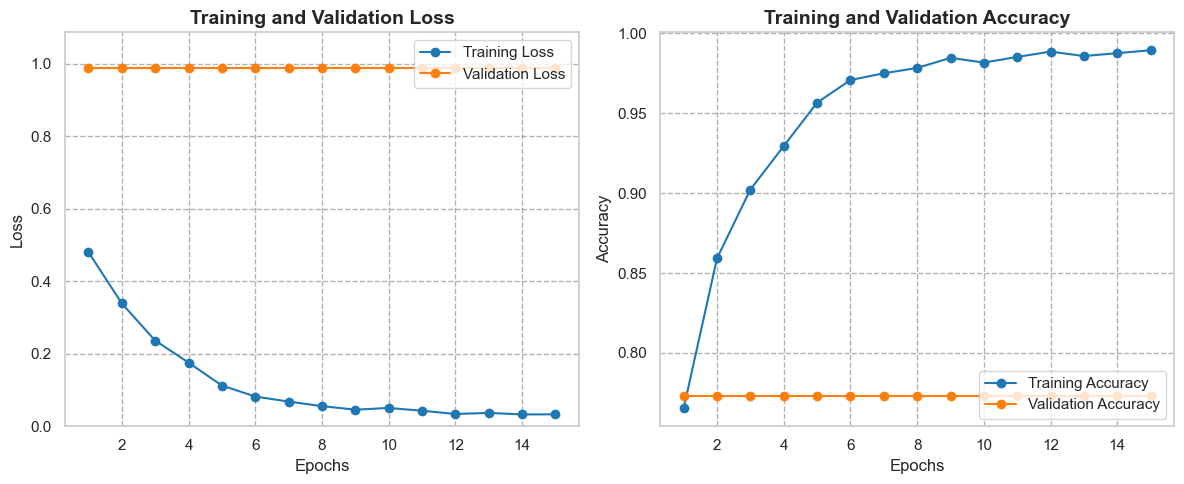

In [46]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=15)

Test Loss: 0.9373, Test Accuracy: 0.7784
Confusion Matrix:
[[500   9]
 [217 294]]


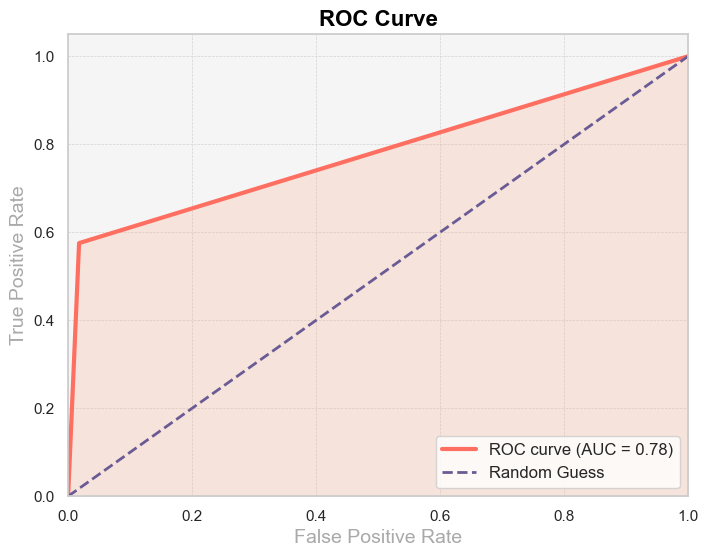

In [47]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

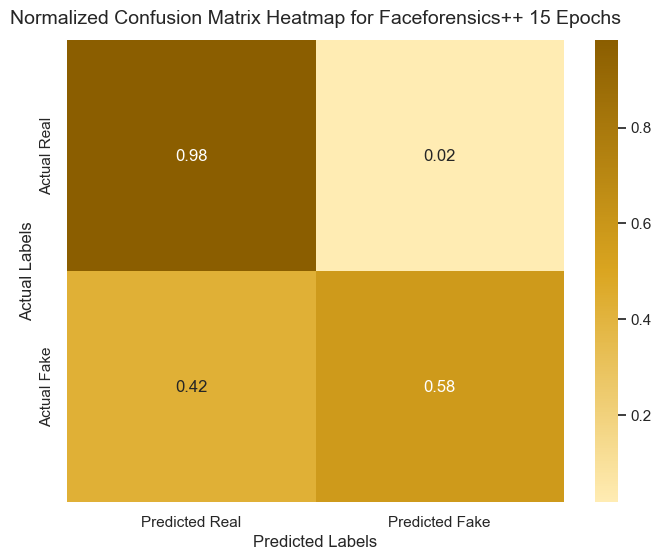

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[500, 9],  # Actual Real
                               [217, 294]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark goldenrod
cmap = LinearSegmentedColormap.from_list("custom_goldenrod", ["#ffecb3", "goldenrod", "#8b5e00"])  # Light to dark goldenrod

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Faceforensics++ 15 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## 15 epc, lr=0.01

In [49]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [50]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=15):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [51]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=15):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [52]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [53]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [54]:
# Run training for 20 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=15)

Epoch 1/15, Train Loss: 0.8117, Train Accuracy: 0.6147
Epoch 2/15, Train Loss: 0.5609, Train Accuracy: 0.7191
Epoch 3/15, Train Loss: 0.4667, Train Accuracy: 0.7774
Epoch 4/15, Train Loss: 0.4044, Train Accuracy: 0.8136
Epoch 5/15, Train Loss: 0.3787, Train Accuracy: 0.8242
Epoch 6/15, Train Loss: 0.3502, Train Accuracy: 0.8405
Epoch 7/15, Train Loss: 0.3050, Train Accuracy: 0.8656
Epoch 8/15, Train Loss: 0.2835, Train Accuracy: 0.8807
Epoch 9/15, Train Loss: 0.2377, Train Accuracy: 0.9043
Epoch 10/15, Train Loss: 0.2069, Train Accuracy: 0.9177
Epoch 11/15, Train Loss: 0.1840, Train Accuracy: 0.9253
Epoch 12/15, Train Loss: 0.1528, Train Accuracy: 0.9410
Epoch 13/15, Train Loss: 0.1551, Train Accuracy: 0.9425
Epoch 14/15, Train Loss: 0.1164, Train Accuracy: 0.9547
Epoch 15/15, Train Loss: 0.0968, Train Accuracy: 0.9634
Training complete.


In [55]:
# Run validation for 15 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=15)

Epoch 1/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 2/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 3/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 4/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 5/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 6/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 7/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 8/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 9/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 10/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 11/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 12/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 13/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 14/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Epoch 15/15, Validation Loss: 0.3695, Validation Accuracy: 0.8734
Validation complete

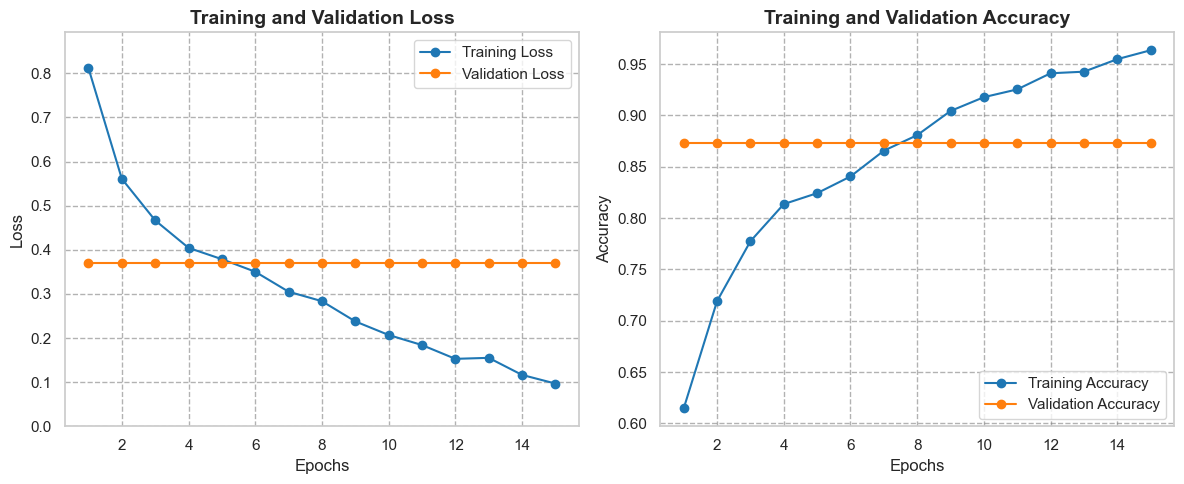

In [56]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=15)

Test Loss: 0.3794, Test Accuracy: 0.8735
Confusion Matrix:
[[382 127]
 [  2 509]]


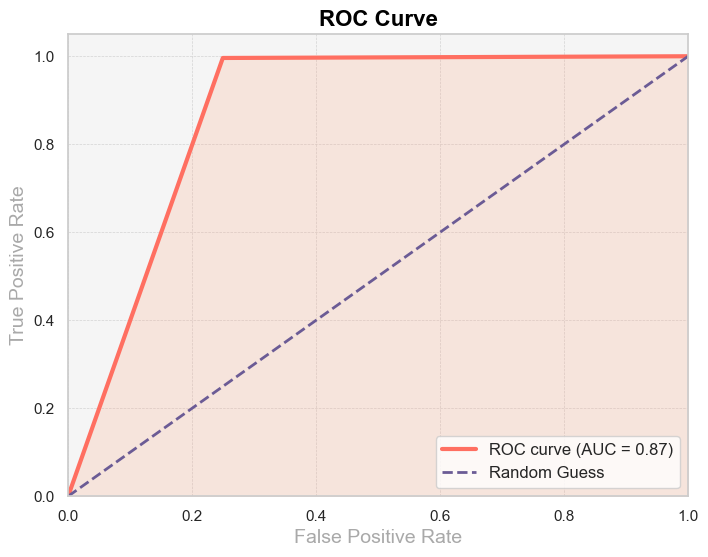

In [57]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

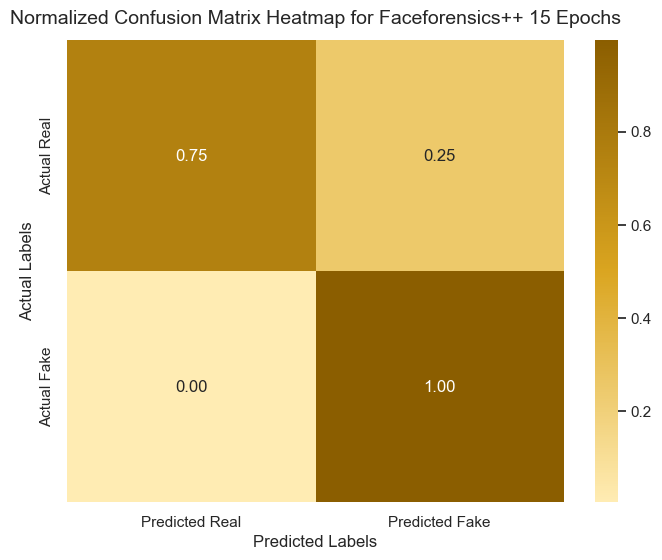

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[382, 127],  # Actual Real
                               [2, 509]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark goldenrod
cmap = LinearSegmentedColormap.from_list("custom_goldenrod", ["#ffecb3", "goldenrod", "#8b5e00"])  # Light to dark goldenrod

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Faceforensics++ 15 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## 20 Epoch, lr=0.0001

In [59]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [60]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=20):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [61]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=20):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [62]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [63]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [64]:
# Run training for 20 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=20)

Epoch 1/20, Train Loss: 0.5141, Train Accuracy: 0.7370
Epoch 2/20, Train Loss: 0.3586, Train Accuracy: 0.8385
Epoch 3/20, Train Loss: 0.2728, Train Accuracy: 0.8865
Epoch 4/20, Train Loss: 0.1957, Train Accuracy: 0.9179
Epoch 5/20, Train Loss: 0.1370, Train Accuracy: 0.9480
Epoch 6/20, Train Loss: 0.1014, Train Accuracy: 0.9606
Epoch 7/20, Train Loss: 0.0701, Train Accuracy: 0.9752
Epoch 8/20, Train Loss: 0.0572, Train Accuracy: 0.9798
Epoch 9/20, Train Loss: 0.0525, Train Accuracy: 0.9826
Epoch 10/20, Train Loss: 0.0333, Train Accuracy: 0.9877
Epoch 11/20, Train Loss: 0.0452, Train Accuracy: 0.9832
Epoch 12/20, Train Loss: 0.0612, Train Accuracy: 0.9800
Epoch 13/20, Train Loss: 0.0318, Train Accuracy: 0.9889
Epoch 14/20, Train Loss: 0.0297, Train Accuracy: 0.9896
Epoch 15/20, Train Loss: 0.0243, Train Accuracy: 0.9916
Epoch 16/20, Train Loss: 0.0083, Train Accuracy: 0.9979
Epoch 17/20, Train Loss: 0.0288, Train Accuracy: 0.9909
Epoch 18/20, Train Loss: 0.0217, Train Accuracy: 0.9940
E

In [65]:
# Run validation for 20 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=20)

Epoch 1/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 2/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 3/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 4/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 5/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 6/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 7/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 8/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 9/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 10/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 11/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 12/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 13/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 14/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 15/20, Validation Loss: 0.0189, Validation Accuracy: 0.9951
Epoch 16/20, Valida

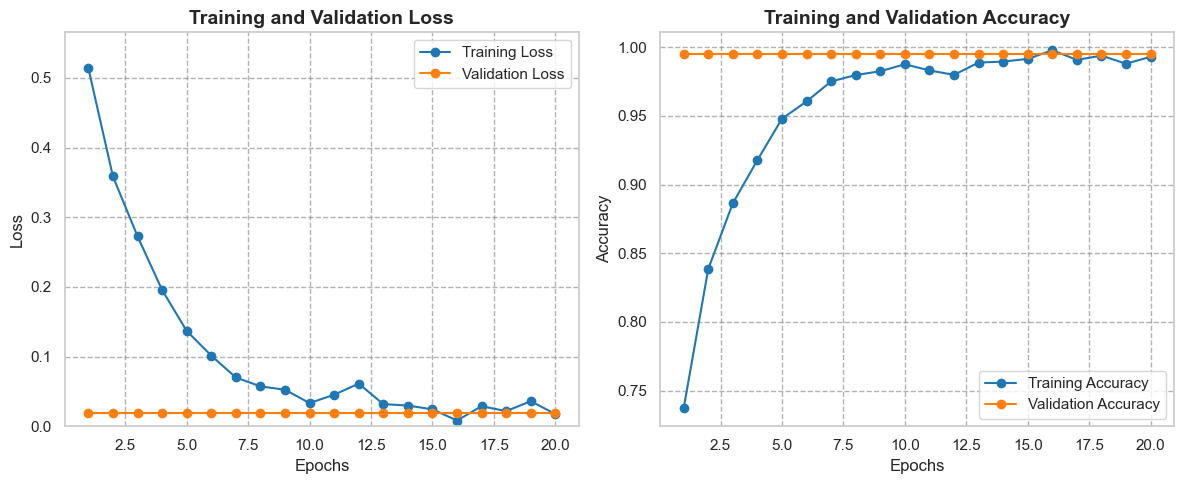

In [66]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=20)

Test Loss: 0.0178, Test Accuracy: 0.9922
Confusion Matrix:
[[509   0]
 [  8 503]]


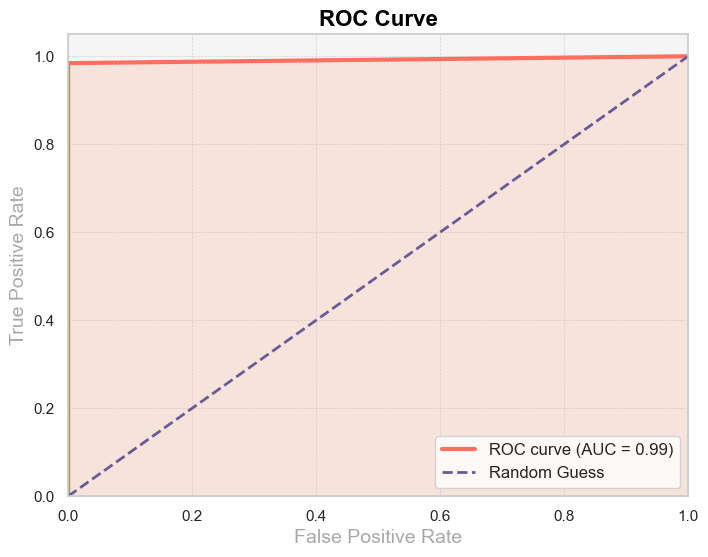

In [67]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

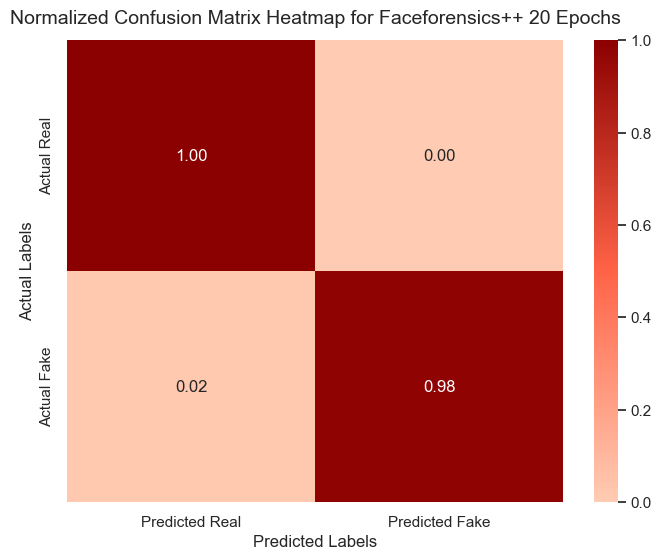

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[509, 0],  # Actual Real
                               [8, 503]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark tomato
cmap = LinearSegmentedColormap.from_list("custom_tomato", ["#ffccb3", "tomato", "#8b0000"])  # Light orange to dark red

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Faceforensics++ 20 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## 20 epc, lr=0.01

In [69]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [70]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=20):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [71]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=20):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [72]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [73]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch):
    epochs = range(1, num_epoch + 1)

    # Create the figure and subplots for loss and accuracy
    plt.figure(figsize=(12, 5))

    # Define more vibrant colors for better visibility
    train_loss_color = '#1f77b4'  
    val_loss_color = '#ff7f0e'    
    train_acc_color = '#1f77b4'   
    val_acc_color = '#ff7f0e'     
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', color=train_loss_color, linestyle='-', label='Training Loss')
    plt.plot(epochs, val_losses, marker='o', color=val_loss_color, linestyle='-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0.0, max(max(train_losses), max(val_losses)) * 1.1)  # Set y-axis limits for loss
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', color=train_acc_color, linestyle='-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, marker='o', color=val_acc_color, linestyle='-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Adjust layout for better spacing between subplots
    plt.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [74]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [75]:
# Run training for 20 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=20)

Epoch 1/20, Train Loss: 0.7595, Train Accuracy: 0.6355
Epoch 2/20, Train Loss: 0.5131, Train Accuracy: 0.7541
Epoch 3/20, Train Loss: 0.4445, Train Accuracy: 0.7902
Epoch 4/20, Train Loss: 0.3703, Train Accuracy: 0.8317
Epoch 5/20, Train Loss: 0.3230, Train Accuracy: 0.8652
Epoch 6/20, Train Loss: 0.2690, Train Accuracy: 0.8859
Epoch 7/20, Train Loss: 0.2185, Train Accuracy: 0.9151
Epoch 8/20, Train Loss: 0.1770, Train Accuracy: 0.9294
Epoch 9/20, Train Loss: 0.1418, Train Accuracy: 0.9470
Epoch 10/20, Train Loss: 0.1289, Train Accuracy: 0.9528
Epoch 11/20, Train Loss: 0.1220, Train Accuracy: 0.9554
Epoch 12/20, Train Loss: 0.0953, Train Accuracy: 0.9665
Epoch 13/20, Train Loss: 0.0979, Train Accuracy: 0.9623
Epoch 14/20, Train Loss: 0.0725, Train Accuracy: 0.9735
Epoch 15/20, Train Loss: 0.0738, Train Accuracy: 0.9743
Epoch 16/20, Train Loss: 0.0651, Train Accuracy: 0.9748
Epoch 17/20, Train Loss: 0.0748, Train Accuracy: 0.9722
Epoch 18/20, Train Loss: 0.0517, Train Accuracy: 0.9832
E

In [76]:
# Run validation for 20 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=20)

Epoch 1/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 2/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 3/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 4/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 5/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 6/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 7/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 8/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 9/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 10/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 11/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 12/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 13/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 14/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 15/20, Validation Loss: 1.7259, Validation Accuracy: 0.7434
Epoch 16/20, Valida

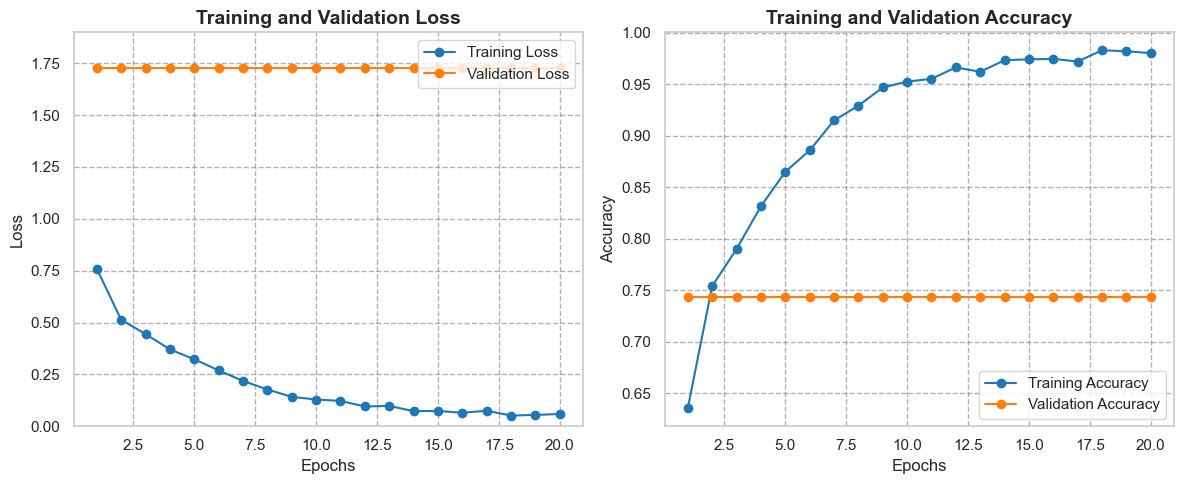

In [77]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=20)

Test Loss: 1.8377, Test Accuracy: 0.7294
Confusion Matrix:
[[503   6]
 [270 241]]


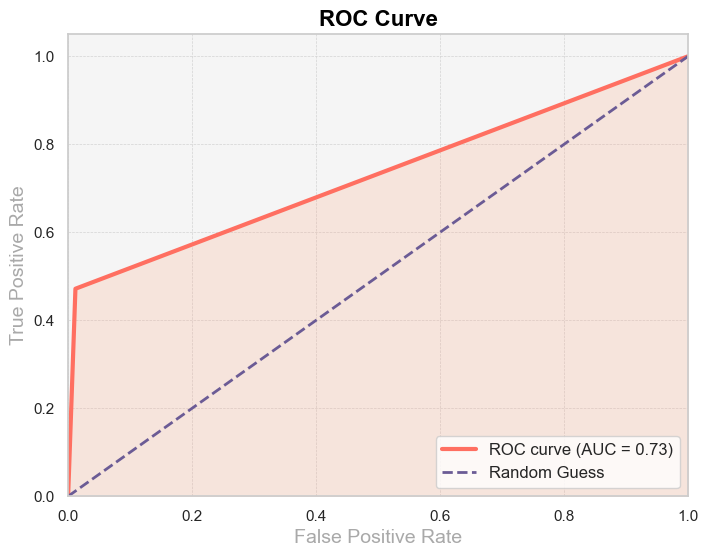

In [78]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

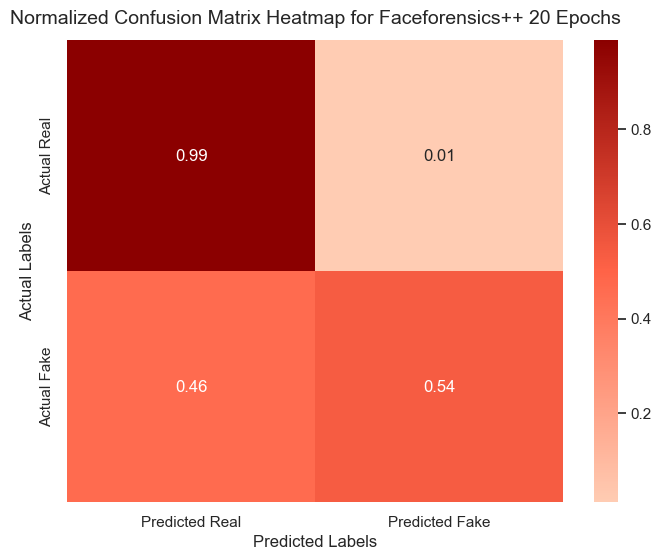

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[503, 6],  # Actual Real
                               [207, 241]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark tomato
cmap = LinearSegmentedColormap.from_list("custom_tomato", ["#ffccb3", "tomato", "#8b0000"])  # Light orange to dark red

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Faceforensics++ 20 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()